## 1. 환경 설정

`(1) Env 환경변수`

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
print(TAVILY_API_KEY[:4])

sk
NY
tvly


`(2) 기본 라이브러리`

In [60]:
import warnings
warnings.filterwarnings("ignore")

from langchain_community.vectorstores import FAISS
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.tools import tool
from langchain_community.tools import TavilySearchResults

from langchain_openai import ChatOpenAI
from langchain_upstage import UpstageEmbeddings
from langchain_upstage import ChatUpstage

# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent

from textwrap import dedent
from typing import List, Literal, Tuple
from pydantic import BaseModel, Field

import gradio as gr

from pprint import pprint

import uuid

#from IPython.display import Image, display

## 2. Tool 정의

`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [15]:

embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    레스토랑 메뉴에서 정보를 검색합니다.
    """
    
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [ ]:

# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """Searches the internet for information that does not exist in the database or for the latest information."""
    
    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

### 2-1. bind_tools() 함수로 LLM과 Tool 연결하기

In [17]:
from langchain_openai import ChatOpenAI

# LLM 모델 
#llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

solar-pro


In [18]:

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"query": '
                                           '"\\uc2a4\\ud14c\\uc774\\ud06c '
                                           '\\uba54\\ub274\\uc758 '
                                           '\\uac00\\uaca9"}',
                              'name': 'search_menu'},
                 'id': 'chatcmpl-tool-588755e4eadc4e628575884de946003e',
                 'type': 'function'}]}


In [19]:
# 도구 호출 ( Tavily )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"query": "2023-2024 recently '
                                           'released open-source LLM models"}',
                              'name': 'search_web'},
                 'id': 'chatcmpl-tool-db685cebd78c4799a4d1e54738c29c6d',
                 'type': 'function'}]}


In [20]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'refusal': None}


In [21]:
pprint(tool_call)

AIMessage(content='3+3은 6입니다. 이 질문은 일반적인 수학 지식을 통해 답할 수 있으므로 함수 호출이 필요하지 않습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 596, 'total_tokens': 620, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': 'f0daed39-070b-4295-8094-1466cb518e5e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--eb8bb7ee-bf42-4619-ae27-26c9eaeee84b-0', usage_metadata={'input_tokens': 596, 'output_tokens': 24, 'total_tokens': 620, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


### 2-2. 도구 노드(ToolNode) 
- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [23]:

# 도구 노드 정의 
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

In [24]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

pprint(tool_call.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"query": '
                                           '"\\uc2a4\\ud14c\\uc774\\ud06c '
                                           '\\uba54\\ub274 \\uac00\\uaca9"}',
                              'name': 'search_menu'},
                 'id': 'chatcmpl-tool-5bfe4af13d02488d94b3e2f12b3ae409',
                 'type': 'function'}]}


`(2) 도구 노드(Tool Node) 실행`


In [25]:
# 도구 호출 결과를 메시지로 추가하여 실행 
results = tool_node.invoke({"messages": [tool_call]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

<Document source="../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="../data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="../data/restaurant_menu.txt"/>
5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.
</Document>

---

<Document source="../data/restaurant_menu.txt"/>
2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한

In [26]:
# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://www.eweek.com/artificial-intelligence/best-large-language-models/"/>
The IBM Granite family of models is a fully open-source LLM released under the Apache v.2 license. The first iteration of these models debuted in May 2024, marking the beginning of an innovative, open-source AI solution for businesses. Following the initial release, Granite 3.0 was introduced in October 2024, followed by Granite 3.1 in December 2024. The latest version, Granite 3.2, was released in February 2025, incorporating new reasoning and vision capabilities into the existing Granite 3.1
</Document>

---

<Document href="https://blog.n8n.io/open-source-llm/"/>
Falcon 3 is the latest iteration of open-source large language models developed by the Technology Innovation Institute (TII) in Abu Dhabi. This family of models demonstrates impressive performance for small LLMs while democratizing access to advanced AI by enabling efficient operation on light infrastructures, including laptops.

⚙️

## 3. ReAct Agent
- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

- 논문: https://arxiv.org/abs/2210.03629

`(1) LangGraph 내장 ReAct 에이전트 사용`

#### LangGraph 내장 ReAct 에이전트인  create_react_agent() 사용한 Basic 예제

In [62]:

from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain.agents import tool
from langchain_core.messages import HumanMessage

# 더 복잡한 도구들 정의
@tool
def calculate_compound_interest(principal: float, rate: float, years: int) -> str:
    """원금, 이자율, 기간을 받아 복리 이자를 계산합니다."""
    amount = principal * (1 + rate/100) ** years
    interest = amount - principal
    return f"{years}년 후 원리금: {amount:,.0f}원, 이자: {interest:,.0f}원"

@tool
def calculate_tax(income: float) -> str:
    """연소득을 받아 간이 세액을 계산합니다."""
    if income <= 12000000:
        tax = income * 0.06
    elif income <= 46000000:
        tax = 720000 + (income - 12000000) * 0.15
    elif income <= 88000000:
        tax = 5820000 + (income - 46000000) * 0.24
    else:
        tax = 15900000 + (income - 88000000) * 0.35
    
    return f"예상 세액: {tax:,.0f}원, 세후 소득: {income - tax:,.0f}원"

@tool
def get_weekday(date_str: str) -> str:
    """YYYY-MM-DD 형식의 날짜를 받아 요일을 반환합니다."""
    from datetime import datetime
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    weekdays = ["월요일", "화요일", "수요일", "목요일", "금요일", "토요일", "일요일"]
    return f"{date_str}은 {weekdays[date_obj.weekday()]}입니다."

# LLM 초기화
#llm = ChatOpenAI(model="gpt-3.5-turbo")
print(llm.model_name)

# 도구 리스트
tools = [calculate_compound_interest, calculate_tax, get_weekday]

# ReAct 에이전트 생성
agent = create_react_agent(llm, tools)

# 복합적인 질문 테스트
complex_questions = [
    "1억원을 연 5% 복리로 10년 동안 예금하면 얼마가 될까?",
    "연소득 5천만원일 때 내야 할 세금은 얼마야?",
    "2024-12-25은 무슨 요일이야?",
    "연소득 8천만원일 때 세금을 계산하고, 남은 돈을 연 4% 복리로 5년간 예금하면 얼마가 돼?"
]

for question in complex_questions:
    print(f"\n질문: {question}")
    print("-" * 50)
    
    result = agent.invoke({"messages": [HumanMessage(content=question)]})
    response = result["messages"][-1].content
    
    print(f"답변: {response}")
    print("=" * 80)

solar-pro

질문: 1억원을 연 5% 복리로 10년 동안 예금하면 얼마가 될까?
--------------------------------------------------
답변: 1억원을 연 5% 복리로 10년 동안 예금할 경우,  
**10년 후 총 금액은 162,889,463원**이며,  
**이자 수익은 62,889,463원**입니다.  

계산 방법:  
\[ A = P \times (1 + r)^n \]  
- \( P = 100,000,000 \)원 (원금)  
- \( r = 5\% = 0.05 \) (연 이자율)  
- \( n = 10 \)년 (기간)  
- \( A \approx 162,889,463 \)원 (10년 후 금액)  

세부 내역:  
- **원금**: 100,000,000원  
- **이자**: 62,889,463원 (복리 계산 기준)  

(참고: 함수는 소수점 반올림된 값을 반환합니다.)

질문: 연소득 5천만원일 때 내야 할 세금은 얼마야?
--------------------------------------------------
답변: 연소득 5천만원일 때 예상 세액은 **6,780,000원**이며, 세후 소득은 **43,220,000원**입니다.  

(단, 이 계산은 간이 세율 기준으로 산출된 예시이며, 실제 세액은 공제 항목, 지역별 세율 등 추가 조건에 따라 달라질 수 있습니다.)

질문: 2024-12-25은 무슨 요일이야?
--------------------------------------------------
답변: 2024-12-25은 **수요일**입니다.  

`get_weekday` 함수를 호출하여 정확히 확인한 결과입니다.

질문: 연소득 8천만원일 때 세금을 계산하고, 남은 돈을 연 4% 복리로 5년간 예금하면 얼마가 돼?
--------------------------------------------------
답변: **계산 결과:**  
1. **세금 계산:**  
   - 연소득 8,

<class 'langgraph.graph.state.CompiledStateGraph'>


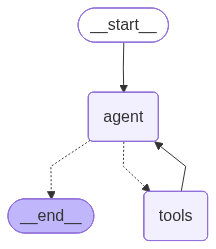

In [27]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    llm, 
    tools=tools, 
)

print(type(graph))

graph
# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

print(type(messages))

for m in messages['messages']:
    print(type(m))
    m.pretty_print()

<class 'langgraph.pregel.io.AddableValuesDict'>
<class 'langchain_core.messages.human.HumanMessage'>
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
<class 'langchain_core.messages.ai.AIMessage'>
================================== Ai Message ==================================

[레스토랑 메뉴에서 스테이크 메뉴의 정확한 가격 정보를 확인하기 위해 `search_menu` 함수를 호출했습니다. 이 함수는 암호화된 데이터베이스에서 승인된 메뉴 정보에 안전하게 접근할 수 있으며, 질문에 직접적으로 필요한 필수 정보를 제공합니다.]
Tool Calls:
  search_menu (chatcmpl-tool-7651eda7dcd04e7893114940b4445d38)
 Call ID: chatcmpl-tool-7651eda7dcd04e7893114940b4445d38
  Args:
    query: 스테이크 메뉴의 가격
<class 'langchain_core.messages.tool.ToolMessage'>
================================= Tool Message =================================
Name: search_menu

<Document source="../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의

In [30]:
inputs = {"messages": [HumanMessage(content="최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?
================================== Ai Message ==================================

[The `search_web` function is ESSENTIAL because the question asks for the latest open-source LLM models, which requires up-to-date information not available in general knowledge. The `search_menu` function is irrelevant here as it pertains to restaurant menus.]  

(Note: After executing this call, the results would typically list models like **Llama 3**, **Mistral v0.3**, **Phi-3**, etc., depending on the current date. Since I cannot browse the web in real-time, this function call is the minimal necessary step to retrieve the answer.)
Tool Calls:
  search_web (chatcmpl-tool-79b139879f4c44b790c71a90d34536c7)
 Call ID: chatcmpl-tool-79b139879f4c44b790c71a90d34536c7
  Args:
    query: recently released open-source large language models
================================= Tool Message =============

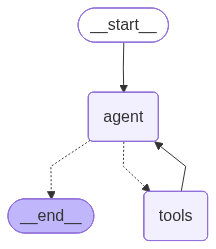

In [33]:
# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

graph


In [34]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")
    ]

messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

`(2) 조건부 엣지 함수를 사용자 정의`
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

In [37]:

# GraphState는 LangGraph의 상태를 정의하는 사용자정의 클래스입니다.
# LangGraph의 MessagesState를 상속받아 메시지 목록을 자동으로 관리합니다.
class GraphState(MessagesState):
    pass

# --- 노드 구성 ---
# call_model 노드는 LLM을 호출하여 응답을 생성합니다.
def call_model(state: GraphState):
    # 시스템 메시지를 정의하여 LLM의 페르소나와 역할을 설정합니다.
    system_message = SystemMessage(content=system_prompt)
    # 기존 메시지 목록 앞에 시스템 메시지를 추가합니다.
    messages = [system_message] + state['messages']
    # 도구 호출 기능이 활성화된 LLM을 호출하여 응답을 받습니다.
    response = llm_with_tools.invoke(messages)
    # LLM의 응답을 상태에 저장하여 반환합니다.
    return {"messages": [response]}

# should_continue 노드는 LLM 응답을 분석하여 다음 단계를 결정하는 라우터 역할을 합니다.
def should_continue(state: GraphState):
    # 가장 마지막 메시지를 가져옵니다.
    last_message = state["messages"][-1]
    
    # 마지막 메시지에 도구 호출이 포함되어 있으면, "execute_tools" 노드로 이동합니다.
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면, 대화를 종료합니다.
    return END

# --- 그래프 구성 ---
# 상태를 관리하는 그래프를 생성합니다.
builder = StateGraph(GraphState)

# 노드들을 그래프에 추가합니다.
# "call_model": LLM을 호출하여 응답을 받는 노드
builder.add_node("call_model", call_model)

"""
ToolNode는 도구 실행에 필요한 복잡한 로직을 미리 구현해 놓은 래퍼(wrapper) 클래스입니다. 
개발자는 단순히 사용하려는 도구 목록(tools)만 전달하면 됩니다.  
직접 함수를 정의해야 한다면, 각 도구의 이름과 입력 인자를 파싱하고, 해당하는 도구를 찾아 실행하는 코드를 수동으로 작성해야 합니다. 
ToolNode는 이 과정을 자동화하여 코드의 양을 크게 줄여줍니다.
"""
builder.add_node("execute_tools", ToolNode(tools))

# --- 엣지(연결) 추가 ---
# START에서 "call_model" 노드로 시작합니다.
builder.add_edge(START, "call_model")

# "call_model" 노드에서 'should_continue' 함수를 사용하여 다음 단계를 결정합니다.
builder.add_conditional_edges(
    "call_model",
    should_continue,
    {
        # 'should_continue'가 "execute_tools"를 반환하면, 해당 노드로 이동합니다.
        "execute_tools": "execute_tools",
        # 'should_continue'가 END를 반환하면, 그래프를 종료합니다.
        END: END
    }
)

# "execute_tools" 노드에서 도구 실행 후, 결과를 가지고 다시 "call_model" 노드로 돌아갑니다.
# 이는 LLM이 도구의 결과를 보고 최종 응답을 생성하도록 합니다.
builder.add_edge("execute_tools", "call_model")

# 그래프를 컴파일하여 실행 가능한 상태로 만듭니다.
graph = builder.compile()
print(type(graph))

# 그래프 출력 
#display(Image(graph.get_graph().draw_mermaid_png()))

<class 'langgraph.graph.state.CompiledStateGraph'>


In [38]:
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	call_model(call_model)
	execute_tools(execute_tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> call_model;
	call_model -.-> __end__;
	call_model -.-> execute_tools;
	execute_tools --> call_model;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://www.mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNptkMsOgjAQRX-lqRtIrA8WLophxSe4U9OUMiNNRiBQEo3x3-UVTKOrzuROz5n2xU2VA5f81ui6YKc0vpQXp1TrdNMfwflYJ0t33NbJNZRSom1aNwwaTaTuPYGCbxkOCTzAdA6UqypqA68LJwWU-SIY6wVPeqIvYiZEwr6C2FczsenjGfI38_Txz3p_8f0SbQrIckDdkWNoieQKI9whrsmWIAqwt8LJ_SbyLoyfM46LqtbGuqfceQPD82ZchtkBDX9_ALpujZU)

In [44]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================

[Brief explanation: The `search_menu` function is ESSENTIAL to answer the question about the steak menu price, as it directly retrieves authorized restaurant menu information from the encrypted database. No other function or general knowledge can provide this specific, confidential data.]  

(After executing the function, the output will be cited as per the required format.)
Tool Calls:
  search_menu (chatcmpl-tool-7be51f47f021427a822cac26031060aa)
 Call ID: chatcmpl-tool-7be51f47f021427a822cac26031060aa
  Args:
    query: 스테이크 메뉴 가격
================================= Tool Message =================================
Name: search_menu

<Document source="../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니

In [40]:
inputs = {"messages": [HumanMessage(content="최근에 가장 많이 사용되는 오픈소스 Javascript 라이브러리들은 어떤 것들이 있나요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

최근에 가장 많이 사용되는 오픈소스 Javascript 라이브러리들은 어떤 것들이 있나요?
================================== Ai Message ==================================

[Brief explanation: The `search_web` function is ESSENTIAL here because the question asks for the *most recent* popular open-source JavaScript libraries, which requires up-to-date information not likely to be in a fixed database like `search_menu`. This function directly addresses the query's temporal requirement ("최근에") and scope.]

I'll now execute the web search to provide a verified, citation-backed answer.  

---  
**Action:** search_web  
**Action Input:** most popular open-source JavaScript libraries 2023  

(After receiving the tool output, I'll cite the source and summarize the results.)
Tool Calls:
  search_web (chatcmpl-tool-18285748b8fb43d7a77595d991f086ff)
 Call ID: chatcmpl-tool-18285748b8fb43d7a77595d991f086ff
  Args:
    query: most popular open-source JavaSc

`(3) tools_condition 활용`
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

In [42]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, START

# --- 노드 함수 정의 ---
# 'call_model' 노드는 LLM을 호출하여 응답을 생성합니다.
def call_model(state: GraphState):
    # 시스템 프롬프트를 정의하여 LLM의 역할을 설정합니다.
    system_message = SystemMessage(content=system_prompt)
    # 기존 메시지 기록 앞에 시스템 메시지를 추가합니다.
    messages = [system_message] + state['messages']
    # 도구 사용이 가능한 LLM을 호출합니다.
    response = llm_with_tools.invoke(messages)
    # LLM의 응답을 상태에 추가합니다.
    return {"messages": [response]}

# --- 그래프 구성 ---
# 상태를 관리하는 그래프 빌더를 생성합니다.
builder = StateGraph(GraphState)

# 노드들을 그래프에 추가합니다.
# "agent": LLM을 호출하는 노드입니다.
builder.add_node("agent", call_model)
# "tools": 도구 호출을 실행하는 내장 노드입니다.
builder.add_node("tools", ToolNode(tools))

# 그래프의 시작점을 설정합니다.
builder.add_edge(START, "agent")

# 'tools_condition'을 사용한 조건부 엣지 추가
# 이 함수는 LLM 응답에 도구 호출이 포함되어 있는지 자동으로 확인하고,
# 다음 노드를 'tools' 또는 'END'로 결정합니다.
# 별도의 라우팅 함수를 만들 필요가 없어 코드가 간결해집니다.
builder.add_conditional_edges(
    # 현재 노드: "agent" (LLM 응답이 생성된 곳)
    "agent",
    # 라우팅 함수: LangGraph의 'tools_condition'
    tools_condition,
)

# 도구 실행이 끝난 후, 다시 'agent' 노드로 돌아가서
# LLM이 도구의 결과를 보고 최종 답변을 생성하도록 합니다.
builder.add_edge("tools", "agent")

# 그래프를 컴파일하여 실행 가능한 상태로 만듭니다.
graph = builder.compile()


In [43]:
# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNpdkc2OgjAQx1-lmb1oAgitAlbjZX2EPe2yMRVaaAItKSVZ1_juW6pLopfpzGT-v_noFUpdcaBQG9Y36OO4K1RhT6fBMuOexde-P8zRftUfvpeUUiHNYKdCVnNlF94up9hq3Q4Lb5d3EFfVjPH-DGnZnTHjURgekGftZjYKI5d8SF_Tvs9u7vuiL12D4cgFqrhgY2uRkG1L3wQWsRBBKxUPGy7rxtIkwk8Cv54vD3XPSmkvNH4qmEZ_4M7inIoSAndAWQEVrB14AB03HZtiuBYKoQJswzteAHXuY5wCCnVzup6pT607oNaMTmn0WDf_wdhXzPKjZO53uhlu3DG4edejskBx4hFAr_ADNHOrZCTGG7JNE7LebgK4AE3WeZSnON_iTU7WGc5vAfz6nnGUZQRnGCcpwXFMsvz2B6g0r_Q)

In [46]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="해산물 메뉴에는 어떤 것들이 있나요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

해산물 메뉴에는 어떤 것들이 있나요?
================================== Ai Message ==================================

[Brief explanation: The `search_menu` function is ESSENTIAL to retrieve the specific restaurant menu items related to seafood, which directly answers the user's question. No other function is necessary as the query is menu-specific and does not require web-based information.]  

(After receiving tool output, the response would include the cited menu details as per the required format.)
Tool Calls:
  search_menu (chatcmpl-tool-f423b604a4f24304bbadd1f5c5f238bb)
 Call ID: chatcmpl-tool-f423b604a4f24304bbadd1f5c5f238bb
  Args:
    query: 해산물 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="../data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 

## 4. MemorySaver

1. 상태의 일시성 문제:
   - 기본적으로 그래프 실행 시 상태는 일시적 (stateless)
   - 그래프를 재실행하는 경우 상태가 초기화되는 문제가 있음 
   - 따라서, 중단이 있는 다중 턴 대화가 어려움 

2. MemorySaver 기능:
   - 가장 쉽게 사용할 수 있는 체크포인터 (각 단계 후 그래프 상태를 자동으로 저장)
   - 그래프 상태를 위한 인메모리 키-값 저장소
   - 지속성(persistence) 있는 메모리 기능을 제공하여 그래프 객체가 체크포인터부터 이어서 실행 가능 

3. 메모리의 필요성:
   - 대화의 연속성: 여러 턴에 걸친 대화를 유지 
   - 중단 허용: 대화 중 중단이 있어도 이전 상태를 복원
   - 유연한 상태 관리: 다양한 대화 스레드를 독립적으로 관리

### 4-1. 사용자 정의 그래프

In [47]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

질문에 메뉴나 선택지 목록이 명시되어 있지 않아 어떤 항목을 추천해야 할지 알 수 없습니다. 추천을 위해 다음 정보가 필요합니다:  

1. 선택 가능한 항목 목록  
2. 추천 기준 (예: 가격, 인기, 맛, 건강성 등)  

예: *"A 레스토랑 메뉴 중 3만 원 이하로 추천해주세요"*와 같이 구체적인 조건을 알려주시면 적절한 도구를 사용해 답변드리겠습니다.  

현재 상태로는 함수 호출이 불필요하며, 추가 정보를 제공해 주시면 바로 도움을 드리겠습니다.


`(1) 체크포인터 지정`
- 그래프를 컴파일할 때 체크포인터를 지정

In [49]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

print(type(builder))
print(type(memory))
print(type(graph_memory))

<class 'langgraph.graph.state.StateGraph'>
<class 'langgraph.checkpoint.memory.InMemorySaver'>
<class 'langgraph.graph.state.CompiledStateGraph'>


`(2) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [50]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================

[Brief explanation: The `search_menu` function is ESSENTIAL to answer the question as it directly retrieves restaurant menu information, including prices for steak items from the authorized database. No other function or general knowledge can provide this specific information.]
Tool Calls:
  search_menu (chatcmpl-tool-6ab457a714844d33b39ba6fec0c58223)
 Call ID: chatcmpl-tool-6ab457a714844d33b39ba6fec0c58223
  Args:
    query: 스테이크 메뉴 가격
================================= Tool Message =================================
Name: search_menu

<Document source="../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</D

In [51]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================

[Brief explanation: The `search_menu` function is ESSENTIAL to answer the question as it directly retrieves restaurant menu information, including prices for steak items from the authorized database. No other function or general knowledge can provide this specific information.]
Tool Calls:
  search_menu (chatcmpl-tool-6ab457a714844d33b39ba6fec0c58223)
 Call ID: chatcmpl-tool-6ab457a714844d33b39ba6fec0c58223
  Args:
    query: 스테이크 메뉴 가격
================================= Tool Message =================================
Name: search_menu

<Document source="../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</D

### 4-2. 내장 ReAct 

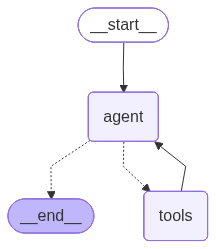

In [53]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.messages import SystemMessage

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    checkpointer=memory,
)
graph

In [ ]:

# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
config = {"configurable": {"thread_id": "2"}}

messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

In [57]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 버섯이 포함된 메뉴가 있나요?")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

## 5. Gradio 챗봇

In [58]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
import uuid

# MemorySaver를 사용하여 그래프의 상태를 메모리에 저장합니다.
# 이를 통해 이전 대화의 맥락을 기억할 수 있습니다.
memory = MemorySaver()

# builder를 컴파일할 때 'checkpointer'를 설정하여 메모리 기능을 활성화합니다.
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들입니다. Gradio UI에 미리 표시되어 사용자가 쉽게 챗봇을 테스트할 수 있습니다.
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 사용자의 메시지를 처리하고 응답을 생성하는 핵심 함수입니다.
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        # LangGraph의 상태 저장소에 접근하기 위한 설정입니다.
        # "thread_id"는 각 대화 세션을 고유하게 식별하는 데 사용됩니다.
        config = {"configurable": {"thread_id": thread_id}}
        
        # 그래프에 전달할 초기 입력입니다. 사용자의 현재 메시지를 담고 있습니다.
        inputs = {"messages": [HumanMessage(content=message)]}
        
        # 설정된 그래프를 호출하여 전체 워크플로우(예: RAG)를 실행합니다.
        # 'graph_memory'는 이전 대화 상태를 자동으로 불러와서 사용합니다.
        result = graph_memory.invoke(inputs, config=config)
        
        # 결과에 'messages'가 포함되어 있으면 응답을 처리합니다.
        if "messages" in result:
            # 현재 스레드 ID와 메시지들을 출력하여 디버깅에 도움을 줍니다.
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                # 메시지를 깔끔한 형식으로 출력합니다.
                msg.pretty_print()

            # 마지막 메시지를 가져옵니다.
            last_message = result["messages"][-1]
            
            # 마지막 메시지가 AI의 응답이면 해당 내용을 반환합니다.
            if isinstance(last_message, AIMessage):
                return last_message.content

        # 응답이 유효하지 않을 경우 반환할 기본 메시지입니다.
        return "응답을 생성하지 못했습니다."

    except Exception as e:
        # 오류 발생 시 오류 메시지를 출력하고, 사용자에게 알립니다.
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

# ChatBot 클래스는 Gradio에 필요한 인터페이스를 제공하고, 각 세션의 thread_id를 관리합니다.
class ChatBot:
    def __init__(self):
        # 챗봇 인스턴스마다 고유한 스레드 ID를 생성합니다.
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        # 현재 스레드 ID를 출력하여 확인합니다.
        print(f"Thread ID: {self.thread_id}")
        # 'process_message' 함수를 호출하여 실제 메시지 처리를 위임합니다.
        response = process_message(message, history, self.thread_id)
        return response

# ChatBot 클래스의 인스턴스를 생성합니다.
chatbot = ChatBot()

# Gradio 채팅 인터페이스를 설정하고, 챗봇의 'chat' 메서드를 연결합니다.
demo = gr.ChatInterface(
    fn=chatbot.chat,  # 사용자가 메시지를 입력하면 호출될 함수
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 애플리케이션을 실행합니다.
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Thread ID: 2d31bf21-98e9-4aec-9dd4-4acdebd23899
스레드 ID: 2d31bf21-98e9-4aec-9dd4-4acdebd23899
================================ Human Message =================================

채식주의자를 위한 메뉴를 추천해주세요.
================================== Ai Message ==================================

[Brief explanation: The `search_menu` function is ESSENTIAL because it directly retrieves vegetarian-friendly menu options from the authorized restaurant database, which is necessary to answer the user's request. No general knowledge or web search can provide the specific menu details required here.]  

(After executing the function, the results will be cited and used to construct the final answer.)  

Example response format based on hypothetical output:  
[Source: search_menu | 채식 메뉴 | ./data/menu.db]  
채식주의자를 위한 추천 메뉴는 다음과 같습니다:  
- 두부 스테이크 (12,000원)  
- 퀴노아 샐러드 (9,500원)  
- 버섯 리조또 (14,000원)  
각 메뉴는 동물성 재료를 사용하지 않으며, 상세한 영양 정보는 메뉴별 설명을 참고해 주세요.
Tool Calls:
  search_menu (chatcmpl-tool-1f6d69eb5e704c62aaade172

In [59]:
# 데모 종료
demo.close()

Closing server running on port: 7860
